# Quantum Classification of CIFAR-10 with Qiskit
In this notebook, we explored the application of quantum computing techniques for the classification of the [CIFAR Dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Leveraging the Qiskit library, we explored the relm of quantum machine learning to enhance our understanding of quantum classifiers.  
Big thanks to [IBM's Qiskit Ecosystem](https://qiskit.org/ecosystem/machine-learning/index.html)!


In [1]:
# Importing Libraries
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss
)
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit import QuantumCircuit
from qiskit.visualization import circuit_drawer

# Imports for CIFAR-10s
from torchvision.datasets import CIFAR10
from torchvision import transforms

### Data Preparation

We are using [CIFAR10 Dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  
The CIFAR-10 dataset, consisting of 60,000 32x32 color images across 10 classes, serves as our testing ground, where we chose only 2 classes to keep both training and testing simple.  

Using prepare_data function we filters the dataset to keep only the specified labels specifically **0(airplane) and 1(automobile)**, and then createing a data loader with the filtered data.


In [2]:
def prepare_data(X, labels_to_keep, batch_size):
    # Filtering out labels (originally 0-9), leaving only labels 0 and 1
    filtered_indices = [i for i in range(len(X.targets)) if X.targets[i] in labels_to_keep]
    X.data = X.data[filtered_indices]
    X.targets = [X.targets[i] for i in filtered_indices]
    
    # Defining dataloader with filtered data
    loader = DataLoader(X, batch_size=batch_size, shuffle=True)
    
    return loader

Here, we prepared our train and test data using previously defined function, where we first **transformed dataset** into tensors and then **normalized using mean and standard deviation**.
Furthermore we set **batch size for loader as 1**.

In [3]:
# Set seed for reproducibility
manual_seed(42)

# CIFAR-10 data transformation
transform = transforms.Compose([
    transforms.ToTensor(), # convert the images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalization usign mean and std.
])

labels_to_keep = [0, 1]
batch_size = 1

# Preparing Train Data
X_train = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = prepare_data(X_train, labels_to_keep, batch_size)

# Preparing Test Data
X_test = CIFAR10(root="./data", train=False, download=True, transform=transform)
test_loader = prepare_data(X_test, labels_to_keep, batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Test dataset size: {len(test_loader.dataset)}")

Training dataset size: 10000
Test dataset size: 2000


### Creating Quantum NN

The QNN is constructed with:
1) Quantum feature map - A function that maps classical data into a quantum Hilbert space, where the feature vectors are quantum states. It is used to transform data into a space where it is easier to process. 
    Here we used [ZZFeatureMap](https://docs.quantum.ibm.com/api/qiskit/0.19/qiskit.circuit.library.ZZFeatureMap) feature map, which entangles qubits based on the pairwise product of input features. 
2) Ansatz -  It is an educated guess about the value or form of an unknown function.
    The ansatz, implemented here is [RealAmplitudes](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes),which introduces parameters that are adjusted during the training process to optimize the quantum model for a specific task. 
    
The overall QNN structure is assembled using a [QuantumCircuit](https://docs.quantum.ibm.com/api/qiskit/circuit), and an [EstimatorQNN](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.neural_networks.EstimatorQNN.html) is instantiated, linking input and weight parameters to facilitate training with input gradients.

In [5]:
# Defining and creating QNN
def create_qnn():
    feature_map = ZZFeatureMap(2) # ZZFeatureMap with 2 bits, entanglement between qubits based on the pairwise product of input features.
    ansatz = RealAmplitudes(2, reps=1) # parameters (angles, in the case of RealAmplitudes) that are adjusted during the training process to optimize the quantum model for a specific task.
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

qnn = create_qnn()

c:\Users\ankra\Documents\Projects\QCNN\cuda\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


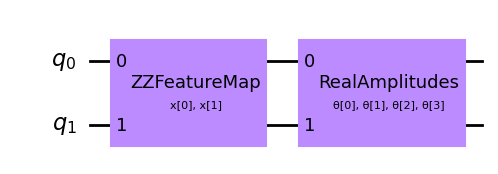

In [6]:
# Visualizing the QNN circuit
circuit_drawer(qnn.circuit, output='mpl')

Now we are defining a Torch Neural Network (NN) module, [Net](https://pytorch.org/docs/stable/generated/torch.nn.Module.html), which incorporates a Quantum Neural Network (QNN).  
The architecture includes convolutional layers (conv1 and conv2), max-pooling layers, dropout regularization, and fully connected layers (fc1, fc2, and fc3). The QNN is integrated using the TorchConnector to handle quantum-classical interface, with a **2-dimensional input and 1-dimensional output** from the QNN. The forward method outlines the data flow through the network, including the QNN processing, making it suitable for quantum-enhanced image classification tasks.

In [7]:
# Defining torch NN module
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = Dropout2d()
        self.fc1 = Linear(32 * 8 * 8, 64)  
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


For training a NN, we have to define an optimizer and here we are using [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) with a **learning rate 0.001** and sets up the [Negative Log Likelihood (NLL)](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) loss function. The training is configured to run for **10 epochs**, and the model.train() call prepares the model for training, indicating that it's in training mode. 

In [8]:
# Creating model
model = Net(qnn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Defining model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = NLLLoss()

# Starting training
epochs = 10
loss_list = []
model.train()


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)

### Training

Training model and printing loss per epoch.

In [9]:

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data to GPU
        optimizer.zero_grad(set_to_none=True)
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


Training [10%]	Loss: -0.4997
Training [20%]	Loss: -0.4999
Training [30%]	Loss: -0.4991
Training [40%]	Loss: -0.4985
Training [50%]	Loss: -0.5001
Training [60%]	Loss: -0.5002
Training [70%]	Loss: -0.5022
Training [80%]	Loss: -0.4953
Training [90%]	Loss: -0.4979
Training [100%]	Loss: -0.4995


Analyzing training loss and saving model.

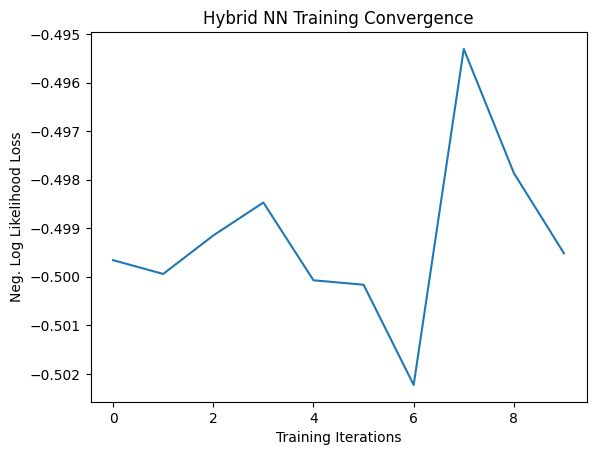

In [10]:
# Plotting loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

# Saving the model
torch.save( model.state_dict(), "model_cifar10_10EPOCHS.pt")

### Testing

In [11]:
# Loading the model
qnn_cifar10 = create_qnn()
model_cifar10 = Net(qnn_cifar10)
model_cifar10.load_state_dict(torch.load("model_cifar10.pt"))

correct = 0
total = 0

model_cifar10.eval()
with torch.no_grad():
    for data, target in test_loader:
        output = model_cifar10(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

# Calculating and print test accuracy
test_accuracy = correct / total * 100
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 49.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


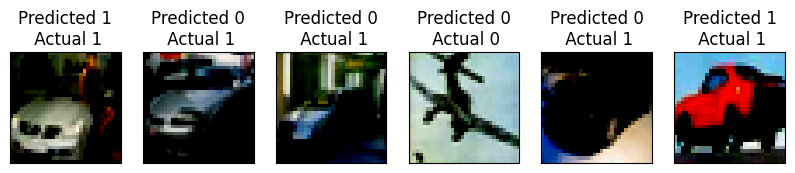

In [12]:
# Plotting predicted labels
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model_cifar10.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model_cifar10(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(np.transpose(data[0].numpy(), (1, 2, 0)))
        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {0}\n Actual {1}".format(pred.item(), target.item()))

        count += 1

plt.show()

### Result

After training the quantum-enhanced neural network on the CIFAR-10 dataset for 10 epochs, the model didnot achieved an accuracy of approximately 49%. Further analysis and optimization may be performed to enhance the performance of the model.  

